# Extra analyses

This notebook provides extra analyses:

1. Plots partial dependence plots for the features
2. Plots model performance with injected noise 
3. Plots model performance with subsampling
4. Plots model performance with different MMGBSA classification thresholds
5. Plots DNA shape results

In [15]:
import re
import os
from pathlib import Path
import joblib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import partial_dependence


## 1. Partial Dependence Plots

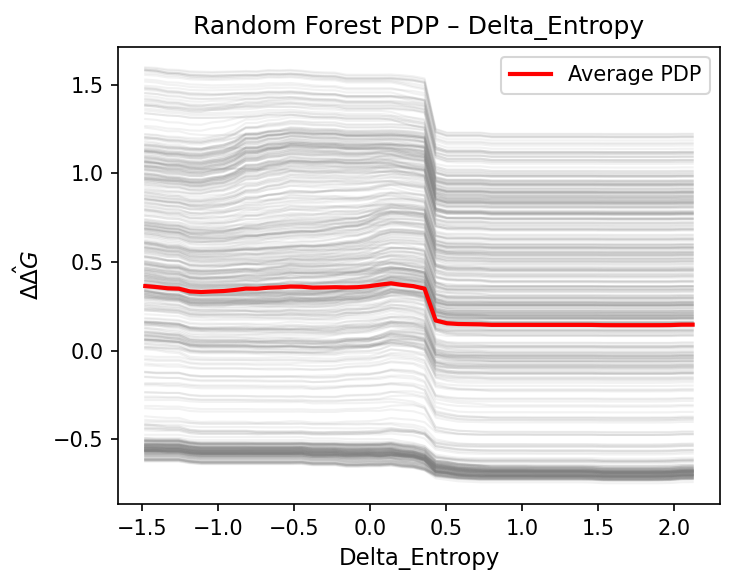

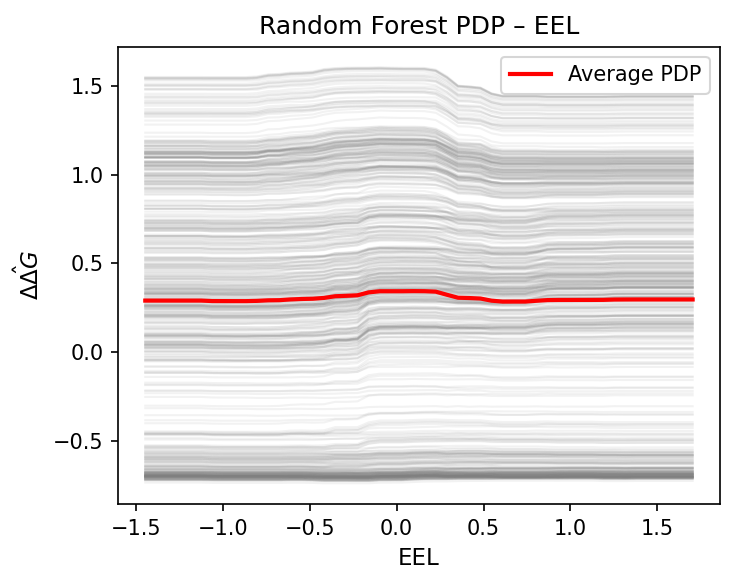

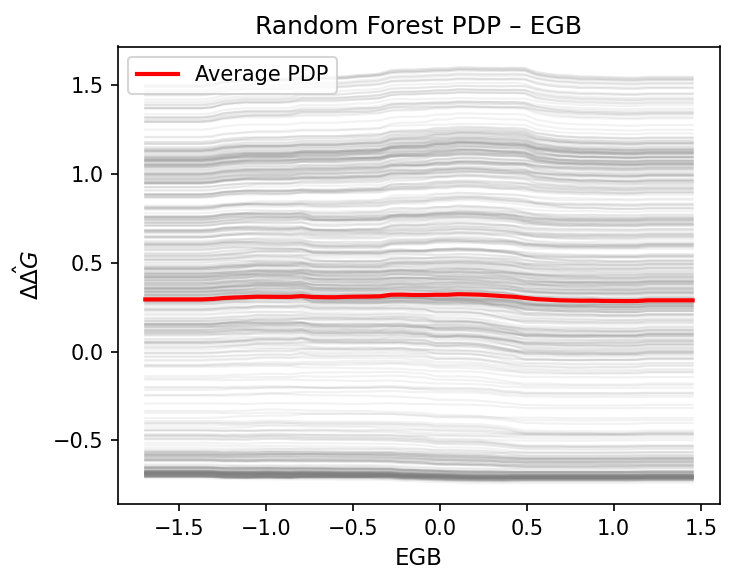

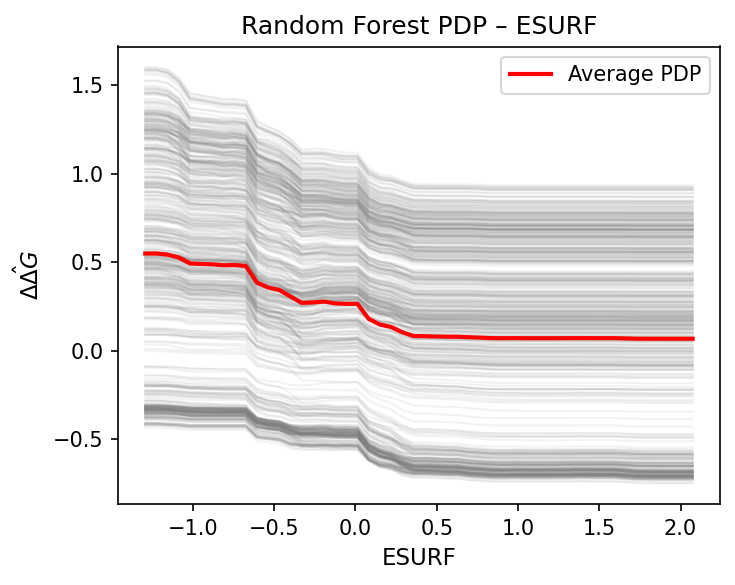

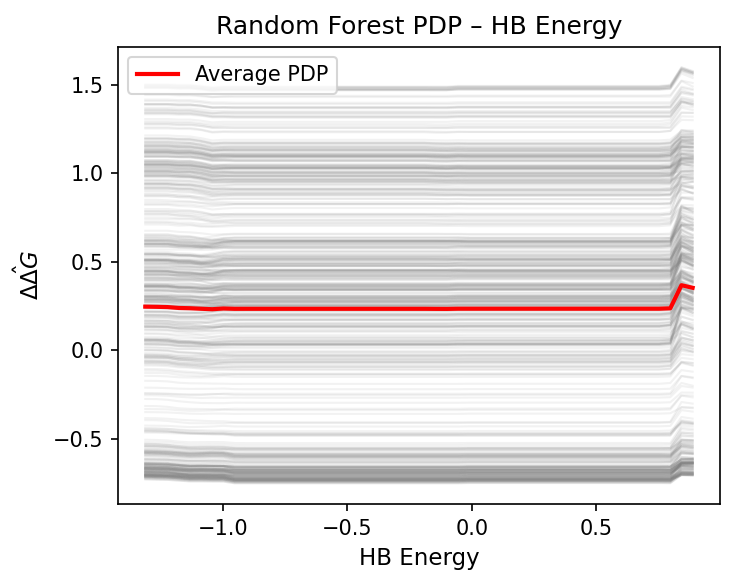

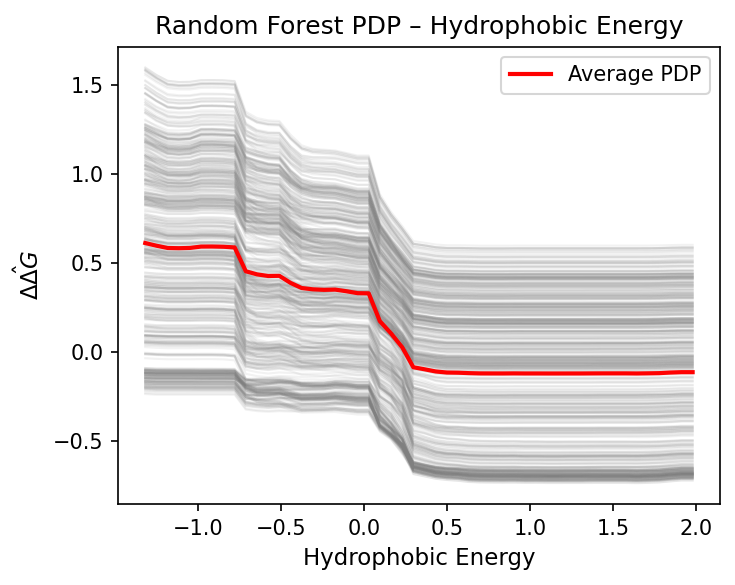

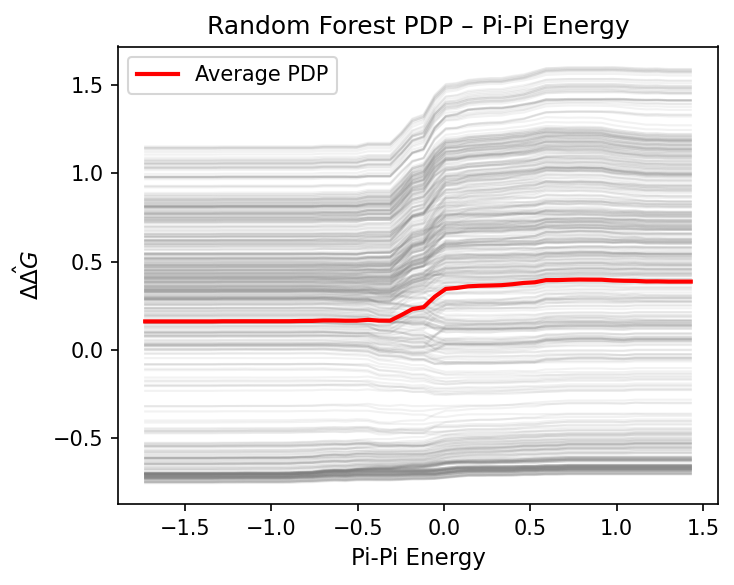

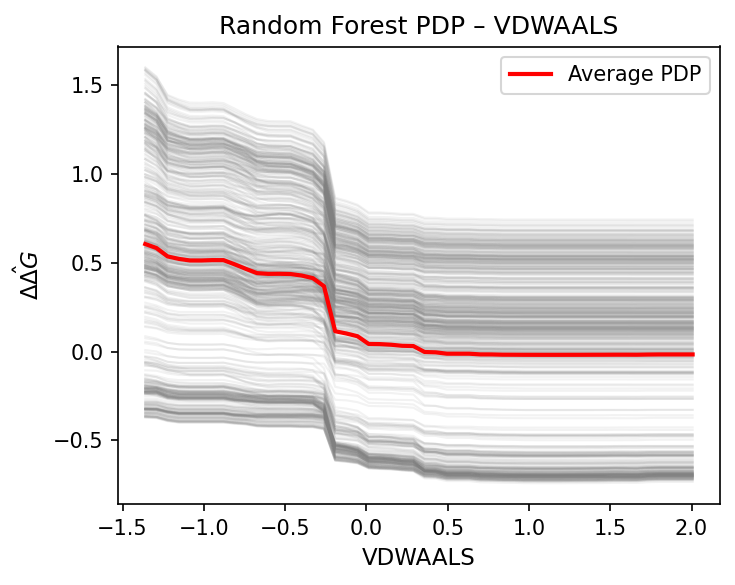

In [14]:
FEATURES_BASE = [
    "Delta_Entropy","EEL","EGB","ESURF","HB Energy",
    "Hydrophobic Energy","Pi-Pi Energy","VDWAALS"
]

def plot_pdp_for_tree_model(model, X_df, feature, model_label="RF", figsize=(5, 4)):
    idx  = X_df.columns.get_loc(feature)
    X_np = X_df.to_numpy(dtype=float, copy=False)

    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message=r"X has feature names, but .* was fitted without feature names",
            category=UserWarning,
            module="sklearn"
        )
        pdp_ind = partial_dependence(model, X_np, [idx], kind="individual", grid_resolution=50)
        pdp_avg = partial_dependence(model, X_np, [idx], kind="average",    grid_resolution=50)

    grid      = pdp_avg["values"][0]
    avg_vals  = pdp_avg["average"][0]
    indiv_all = pdp_ind["individual"][0]

    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    for curve in indiv_all:
        ax.plot(grid, curve, color="grey", alpha=0.1, linewidth=1)
    ax.plot(grid, avg_vals, color="red", linewidth=2, label="Average PDP")
    ax.set_title(f"{model_label} PDP – {feature}", fontsize=12)
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel(r"$\hat{\Delta\Delta G}$", fontsize=11)
    ax.legend(fontsize=10)
    plt.tight_layout(); plt.show()

# -------------------------
# Minimal loader (RF fold)
# -------------------------
def load_training_df(folder, model_prefix="rf", rep=1, fold=1, scr_frac=0.00, model_type="reg"):
    """
    Load a trained model and its corresponding training CSV, then
    return (model, X_df_with_only_features).
    Expects:
      Model/{prefix}_fold_{rep}_{fold}_{model_type}_scr{0p00}.pkl
      Data/ gbsa_{model_type}_scr{0p00}_trn_{rep}_{fold}.csv
    """
    scr_str   = f"{scr_frac:.2f}".replace(".", "p")
    model_path= Path(folder, "Model", f"{model_prefix}_fold_{rep}_{fold}_{model_type}_scr{scr_str}.pkl")
    data_csv  = Path(folder, "Data",  f"gbsa_{model_type}_scr{scr_str}_trn_{rep}_{fold}.csv")

    if not model_path.is_file():
        print(f"Model not found: {model_path}")
        return None, None
    if not data_csv.is_file():
        print(f"Training CSV not found: {data_csv}")
        return None, None

    model = joblib.load(model_path)
    X_df  = pd.read_csv(data_csv)

    feats = FEATURES_BASE
    feats = [f for f in feats if f in X_df.columns]  # keep only present cols
    if not feats:
        print("No matching feature columns found in training CSV.")
        return None, None

    return model, X_df[feats]

# -------------------------
# Example usage
# -------------------------
folder = "../ML_RF_scramble"  
model, X = load_training_df(folder, model_prefix="rf", rep=1, fold=1, scr_frac=0.00, model_type="reg")
if model is not None:
    for feat in FEATURES_BASE:
        if feat in X.columns:
            plot_pdp_for_tree_model(model, X, feature=feat, model_label="Random Forest")


## 2. Injected Noise

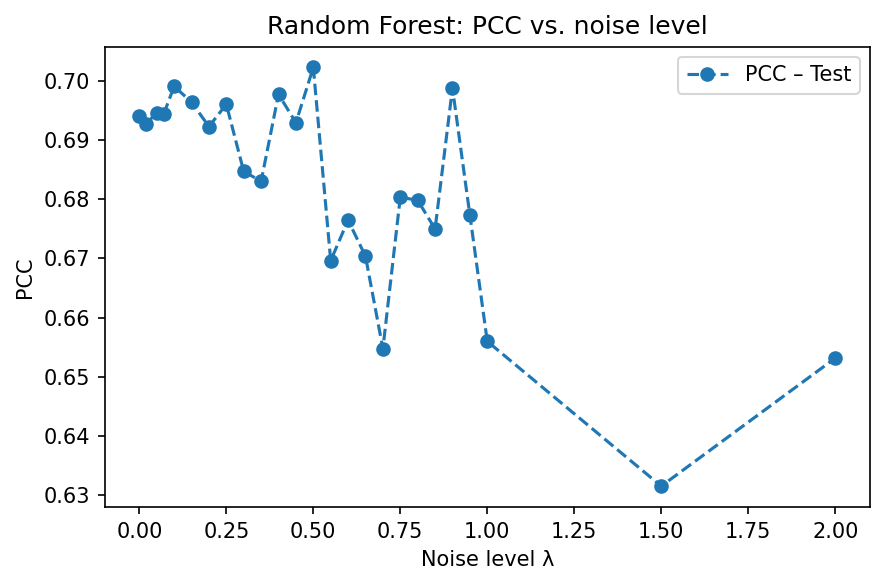

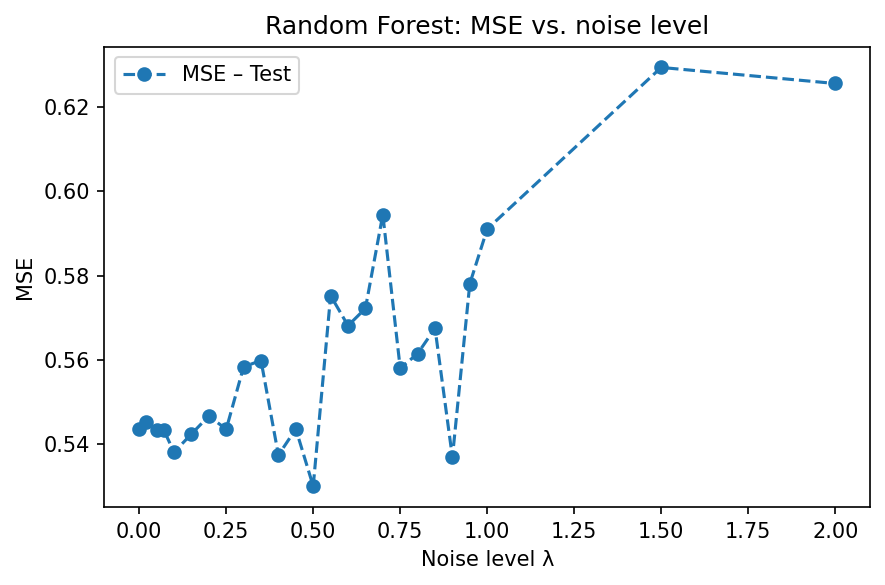

In [2]:
def load_csv(file_path, rename_map=None):
    df = pd.read_csv(file_path)
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
    return df


def parse_filename_info(file_name: str):
    """
    Recognizes:
      • CV/train predictions:
          predictions_<type>_scr0p00_noi05_rep1_fold2.csv
      • Final test predictions:
          predictions_test_<type>_scr0p00_noi05.csv
    Returns dict with: model_type, scr_frac, noise_level, rep, fold, is_test
    """
    # CV / train files
    m = re.match(
        r"predictions_(reg|bin|mclass)_scr([\d]+p[\d]+)_noi(\d+)_rep(\d+)_fold(\d+)\.csv",
        file_name
    )
    if m:
        return dict(
            model_type=m.group(1),
            scr_frac=float(m.group(2).replace("p", ".")),
            noise_level=int(m.group(3)) / 100.0,
            rep=int(m.group(4)),
            fold=int(m.group(5)),
            is_test=False,
        )

    # Test files
    m2 = re.match(
        r"predictions_test_(reg|bin|mclass)_scr([\d]+p[\d]+)_noi(\d+)\.csv",
        file_name
    )
    if m2:
        return dict(
            model_type=m2.group(1),
            scr_frac=float(m2.group(2).replace("p", ".")),
            noise_level=int(m2.group(3)) / 100.0,
            rep=None,
            fold=None,
            is_test=True,
        )
    return None


def collect_regression_predictions_with_noise(data_folder: str) -> pd.DataFrame:
    """
    Scan a folder for predictions_* CSVs, keep only **regression** files,
    and attach noise metadata for plotting (noise_level, is_test, etc).
    """
    csv_paths = list(Path(data_folder).glob("predictions_*.csv"))
    out = []

    for p in csv_paths:
        info = parse_filename_info(p.name)
        if not info or info["model_type"] != "reg":
            continue

        df = load_csv(p, {"Predicted": "Predicted_reg", "True": "True_reg"})
        df["scr_frac"] = info["scr_frac"]
        df["noise_level"] = info["noise_level"]
        df["is_test"] = info["is_test"]
        df["rep"] = info["rep"]
        df["fold"] = info["fold"]
        out.append(df)

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()


def plot_noise_stability(df_reg: pd.DataFrame, title: str = "Model"):
    """
    Plot PCC and MSE vs. injected noise level λ for train (solid) and test (dashed).
    Requires columns: True_reg, Predicted_reg, noise_level, is_test.
    """
    if df_reg.empty:
        print("No regression predictions found.")
        return

    for metric in ["pcc", "mse"]:
        plt.figure(figsize=(6, 4), dpi=150)
        for test_flag, ls in zip([False, True], ["-", "--"]):
            dsub = df_reg[df_reg["is_test"] == test_flag]
            if dsub.empty:
                continue

            # Aggregate per noise_level
            if metric == "pcc":
                series = dsub.groupby("noise_level").apply(
                    lambda d: pearsonr(d["True_reg"], d["Predicted_reg"])[0]
                )
            else:  # mse
                series = dsub.groupby("noise_level").apply(
                    lambda d: mean_squared_error(d["True_reg"], d["Predicted_reg"])
                )

            df_plot = (
                series.to_frame(metric.upper())
                .reset_index()
                .sort_values("noise_level")
            )

            plt.plot(
                df_plot["noise_level"],
                df_plot[metric.upper()],
                marker="o",
                linestyle=ls,
                label=f"{metric.upper()} – {'Test' if test_flag else 'Train'}",
            )

        plt.xlabel("Noise level λ")
        plt.ylabel(metric.upper())
        plt.title(f"{title}: {metric.upper()} vs. noise level")
        plt.legend()
        plt.tight_layout()
        plt.show()


# ─── Example usage ──────────────────────────────────────────────────────────
folder = "../ML_RF_scramble_noise"      # path containing predictions_*_noiXX*.csv
df_reg = collect_regression_predictions_with_noise(folder)
plot_noise_stability(df_reg, title="Random Forest")

## Subsampling

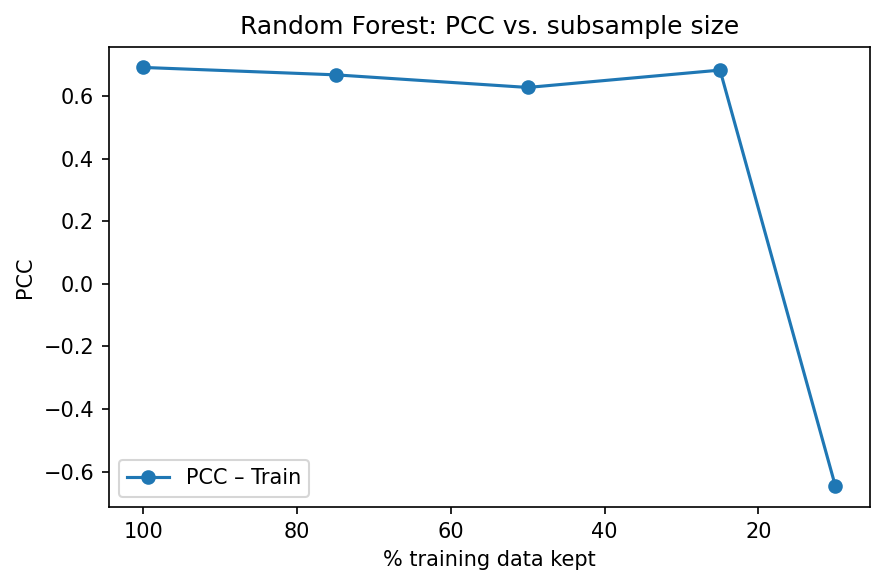

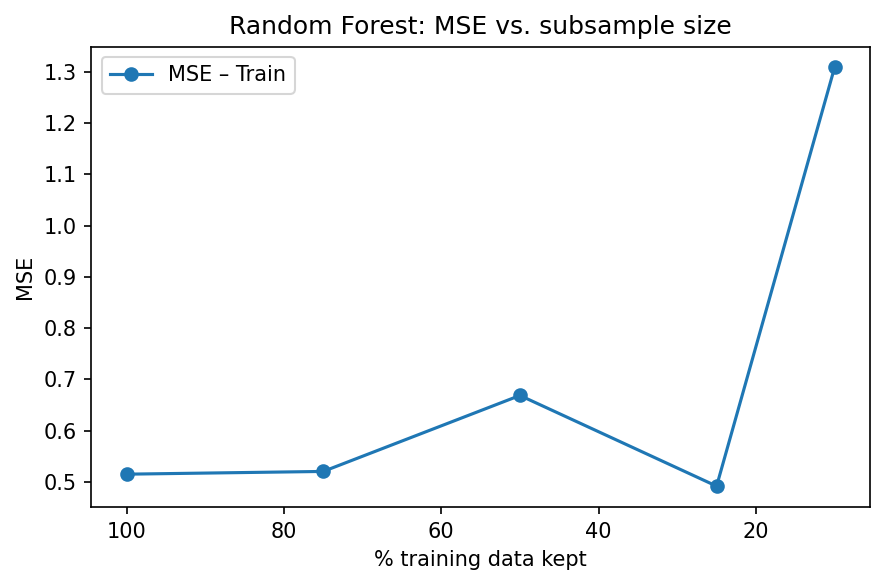

In [3]:
def load_csv(file_path, rename_map=None):
    df = pd.read_csv(file_path)
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
    return df


def parse_filename_info(file_name: str):
    """
    Expected training-prediction filenames (from run_model_rf.py):
        predictions_reg_scr0p00_sub75_rep1_fold2.csv
    (We parse test names too, but we won't plot them.)
        predictions_test_reg_scr0p00_sub75.csv
    """
    # train / val predictions
    m = re.match(
        r"predictions_(reg)_scr([\d]+p[\d]+)_sub(\d+)_rep(\d+)_fold(\d+)\.csv",
        file_name
    )
    if m:
        return dict(
            model_type=m.group(1),
            scr_frac=float(m.group(2).replace("p", ".")),
            sub_pct=int(m.group(3)),   # 25, 50, 75, 100 …
            rep=int(m.group(4)),
            fold=int(m.group(5)),
            is_test=False,
        )

    # (optional) test predictions; parsed but not plotted
    m2 = re.match(
        r"predictions_test_(reg)_scr([\d]+p[\d]+)_sub(\d+)\.csv",
        file_name
    )
    if m2:
        return dict(
            model_type=m2.group(1),
            scr_frac=float(m2.group(2).replace("p", ".")),
            sub_pct=int(m2.group(3)),
            rep=None, fold=None,
            is_test=True,
        )
    return None


def collect_regression_predictions_with_subsample(data_folder: str) -> pd.DataFrame:
    """
    Scan folder for predictions_* CSVs, keep only **regression** files,
    and attach subsample metadata (sub_pct, is_test, etc).
    """
    csv_paths = list(Path(data_folder).glob("predictions_*.csv"))
    out = []

    for p in csv_paths:
        info = parse_filename_info(p.name)
        if not info or info["model_type"] != "reg":
            continue

        df = load_csv(p, {"Predicted": "Predicted_reg", "True": "True_reg"})
        df["scr_frac"] = info["scr_frac"]
        df["sub_pct"] = info["sub_pct"]
        df["is_test"] = info["is_test"]
        df["rep"] = info["rep"]
        df["fold"] = info["fold"]
        out.append(df)

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()


def _safe_pcc(y_true, y_pred):
    if len(y_true) < 2:
        return np.nan
    try:
        return pearsonr(y_true, y_pred)[0]
    except Exception:
        return np.nan


def plot_subsample_stability_train_only(df_reg: pd.DataFrame, title: str = "Random Forest"):
    """
    Plot PCC and MSE vs. subsample percentage (TRAIN curves only).
    Requires columns: True_reg, Predicted_reg, sub_pct, is_test.
    """
    if df_reg.empty:
        print("No regression predictions found.")
        return

    # Keep TRAIN only
    df_tr = df_reg[df_reg["is_test"] == False].copy()
    if df_tr.empty:
        print("No train predictions found.")
        return

    for metric in ["pcc", "mse"]:
        plt.figure(figsize=(6, 4), dpi=150)

        grp = df_tr.groupby("sub_pct")
        if metric == "pcc":
            series = grp.apply(lambda d: _safe_pcc(d["True_reg"], d["Predicted_reg"]))
        else:  # mse
            series = grp.apply(lambda d: mean_squared_error(d["True_reg"], d["Predicted_reg"]))

        df_plot = (
            series.to_frame(metric.upper())
                  .reset_index()
                  .sort_values("sub_pct")
        )

        if df_plot.empty:
            continue

        plt.plot(
            df_plot["sub_pct"], df_plot[metric.upper()],
            marker="o", linestyle="-", label=f"{metric.upper()} – Train"
        )

        plt.gca().invert_xaxis()  # show 100% → smaller %
        plt.xlabel("% training data kept")
        plt.ylabel(metric.upper())
        plt.title(f"{title}: {metric.upper()} vs. subsample size")
        plt.legend()
        plt.tight_layout()
        plt.show()


# ─── Example usage ──────────────────────────────────────────────────────────
folder = "../ML_RF_scramble_subsample"  # path containing predictions_*_subXX*.csv
df_reg = collect_regression_predictions_with_subsample(folder)
# Optional: focus on a specific scramble fraction
df_reg = df_reg[df_reg["scr_frac"] == 0.0]
plot_subsample_stability_train_only(df_reg, title="Random Forest")


## MMGBSA Classification Thresholding

Optimal MMGBSA threshold  : 0.5925
Accuracy @ optimal thrsh.: 0.8060
F1  (non‑binding positive): 0.7234
Approx. experimental log‑intensity threshold: 0.3096



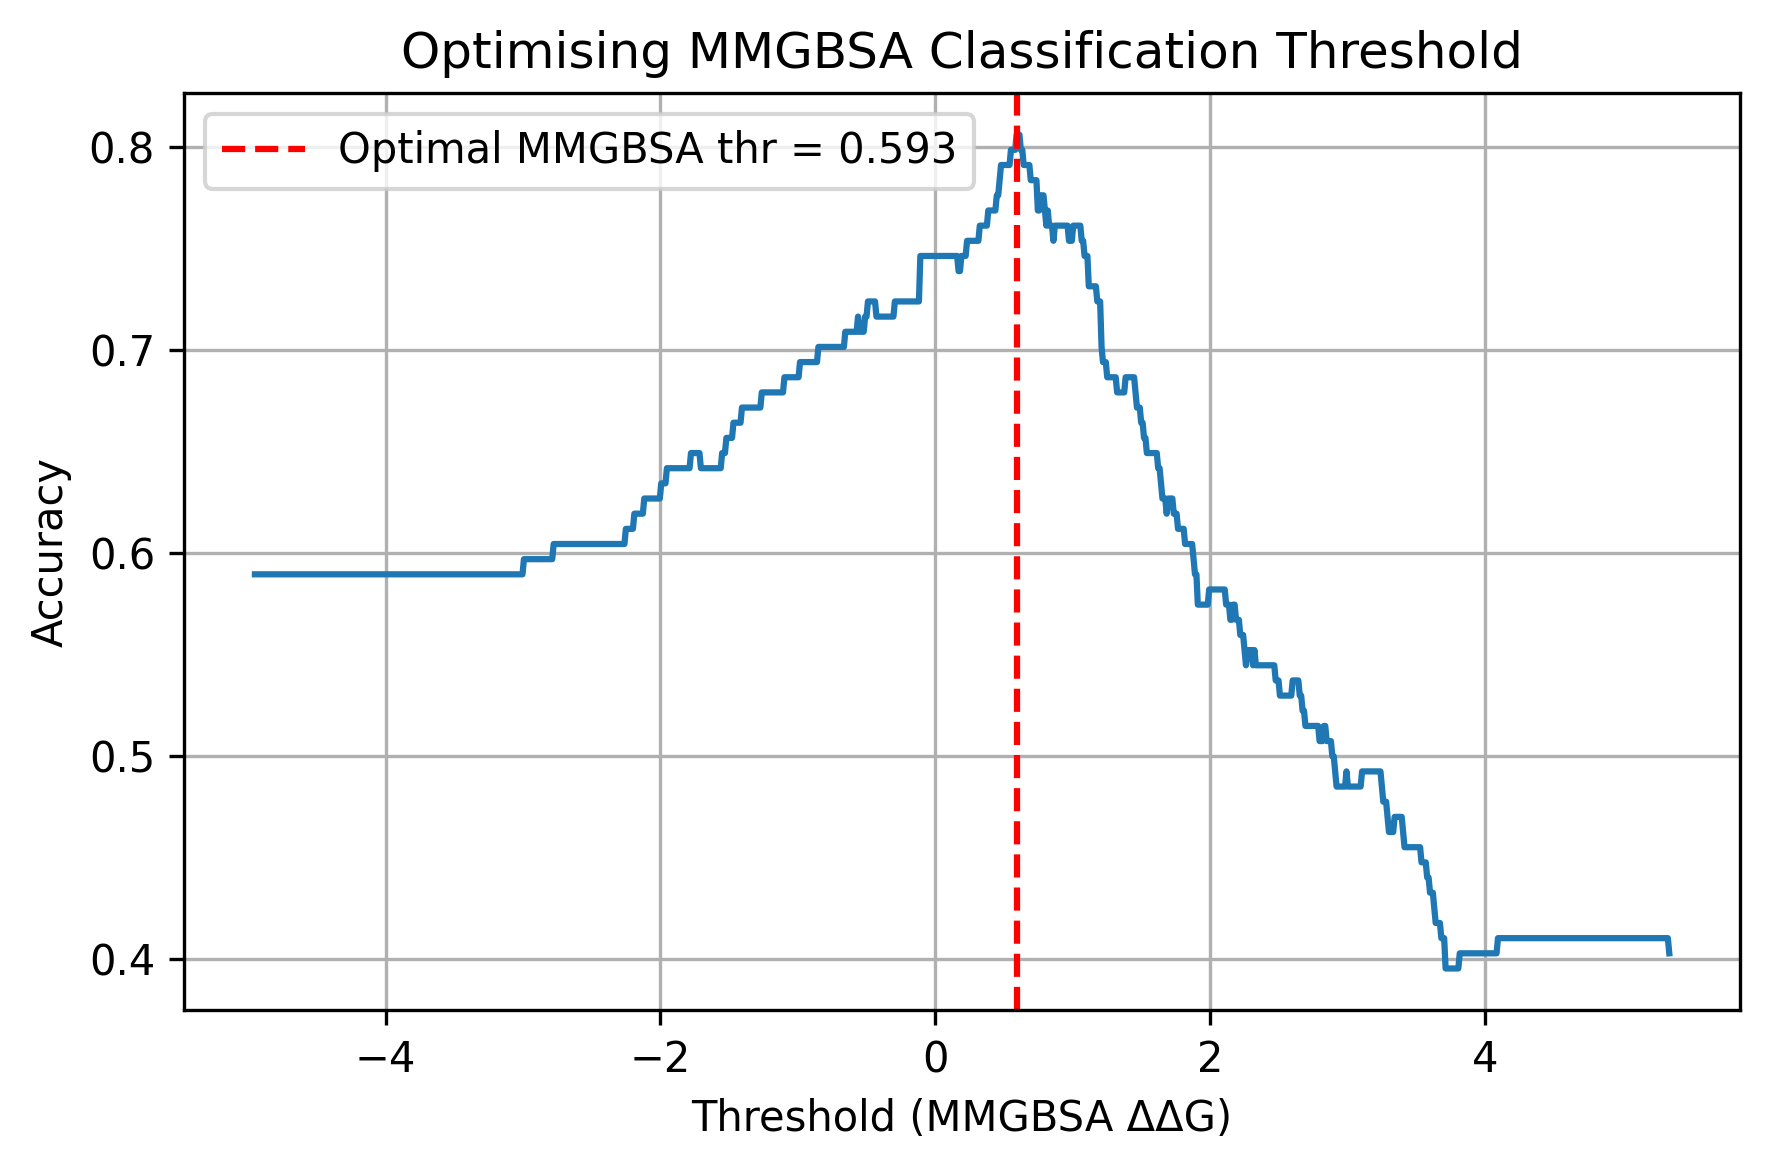

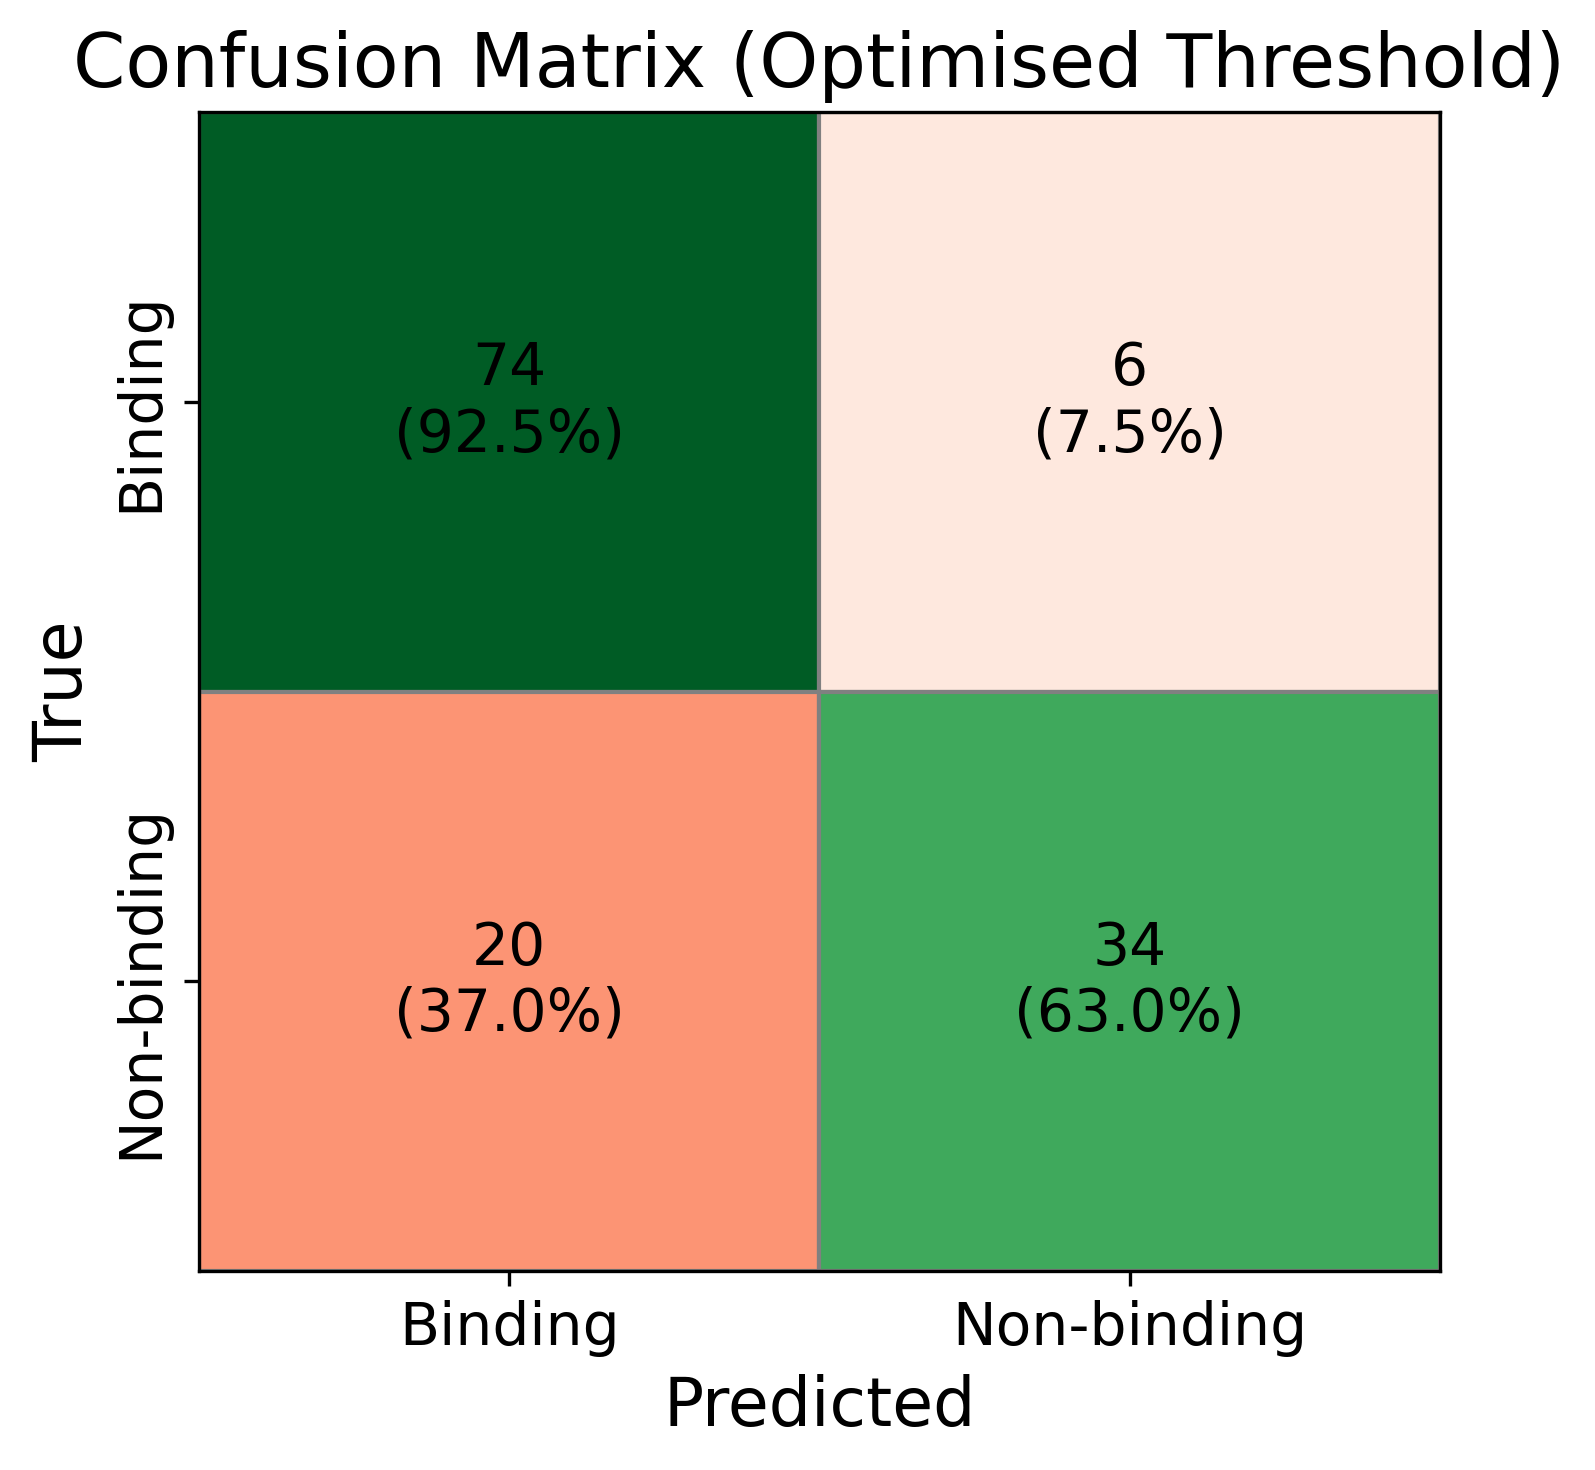

In [8]:
def build_df_train(
    train_split_csv,
    raw_csv,
    exp_csv,
    seq_col="sequence",
    exp_col="bind_avg",
    energy_cols=("VDWAALS","EEL","EGB","ESURF","HB Energy","Hydrophobic Energy","Pi-Pi Energy","Delta_Entropy"),
    sign_flip=True,
):
    # 1) which sequences are in the training split?
    df_trn_split = pd.read_csv(train_split_csv)
    train_seqs = set(df_trn_split[seq_col])

    # 2) load raw frames + experimental labels (dedup per sequence)
    raw = pd.read_csv(raw_csv)
    exp = pd.read_csv(exp_csv)[[seq_col, exp_col]].drop_duplicates()

    # keep only training sequences
    raw = raw[raw[seq_col].isin(train_seqs)].copy()
    exp_tr = exp[exp[seq_col].isin(train_seqs)].copy()
    if exp_tr.empty:
        raise ValueError("No experimental entries for training sequences.")

    # 3) z-score MM/GBSA terms per frame and sum them
    scaler = StandardScaler().fit(raw[list(energy_cols)])
    z_terms = pd.DataFrame(scaler.transform(raw[list(energy_cols)]),
                           columns=energy_cols, index=raw.index)
    raw["sum_z_terms"] = z_terms.sum(axis=1)

    # 4) choose reference sequence: minimal |experimental| value
    ref_idx = exp_tr[exp_col].abs().idxmin()
    ref_seq = exp_tr.loc[ref_idx, seq_col]
    ref_sum_mean = raw.loc[raw[seq_col] == ref_seq, "sum_z_terms"].mean()

    # 5) per-sequence mean/std of delta to reference
    raw["delta_frame"] = raw["sum_z_terms"] - ref_sum_mean
    grp = raw.groupby(seq_col)["delta_frame"]
    pred_seq = pd.DataFrame({
        seq_col: grp.mean().index,
        "pred_mean": grp.mean().values,
        "pred_std":  grp.std(ddof=0).fillna(0.0).values
    })

    # 6) align sign and merge experimental → df_train with y_pred / y_true
    pred_seq["y_pred"] = -pred_seq["pred_mean"] if sign_flip else pred_seq["pred_mean"]
    pred_seq["yerr"]   =  pred_seq["pred_std"]

    df_train = pred_seq.merge(exp_tr, on=seq_col, how="inner") \
                       .rename(columns={exp_col: "y_true"})
    return df_train

# ---- example usage (fill in your paths/vars) ----
DATA_DIR = "."
SCR_STR  = "scr0p00"
TRAIN_SPLIT = os.path.join(DATA_DIR, f"gbsa_reg_{SCR_STR}_trn_final.csv")
RAWDAT      = "rawdat.csv"
EXP_FILE    = "exp_data_all.csv"

df_train = build_df_train(
    train_split_csv=TRAIN_SPLIT,
    raw_csv=RAWDAT,
    exp_csv=EXP_FILE,
    seq_col="sequence",
    exp_col="bind_avg",
    energy_cols=("VDWAALS","EEL","EGB","ESURF","HB Energy","Hydrophobic Energy","Pi-Pi Energy","Delta_Entropy"),
    sign_flip=True,
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# ------------------------------
# CONFIG
# ------------------------------
# df_train must already exist in the session (merged MMGBSA + experimental)
# and have the columns y_pred (MMGBSA ΔΔG) and y_true (experimental log‑intensity/ΔΔG)
# If you need to load from disk, just replace the next line accordingly.
# -----------------------------------------------------------------------

df = df_train.rename(columns={"y_pred": "mmgbsa_ddg", "y_true": "exp_ddg"}).copy()

# Treat experimental ΔΔG > 0  ⇒ binding (class 1), else non‑binding (class 0)
df["true_label"] = (df["exp_ddg"] > 0).astype(int)

# -----------------------------------------------------------------------
# 1)  Find MMGBSA threshold that maximises accuracy
# -----------------------------------------------------------------------
thresholds = np.linspace(df["mmgbsa_ddg"].min(), df["mmgbsa_ddg"].max(), 1000)
accuracies = [accuracy_score(df["true_label"], (df["mmgbsa_ddg"] > t).astype(int))
              for t in thresholds]

best_idx           = int(np.argmax(accuracies))
optimal_threshold  = thresholds[best_idx]
optimal_accuracy   = accuracies[best_idx]

df["optimized_pred"] = (df["mmgbsa_ddg"] > optimal_threshold).astype(int)
optimal_f1 = f1_score(df["true_label"], df["optimized_pred"], pos_label=0)
optimal_cm = confusion_matrix(df["true_label"], df["optimized_pred"], labels=[1, 0])

print(f"Optimal MMGBSA threshold  : {optimal_threshold:.4f}")
print(f"Accuracy @ optimal thrsh.: {optimal_accuracy:.4f}")
print(f"F1  (non‑binding positive): {optimal_f1:.4f}")

# -----------------------------------------------------------------------
# 2)  Approximate experimental log‑intensity (exp_ddg) that corresponds
#     to the MMGBSA threshold.
#     We take the k sequences whose MMGBSA ΔΔG is closest to the threshold
#     (k = 5 or fewer if dataset is small) and average their exp_ddg.
# -----------------------------------------------------------------------

df["dist_to_opt"] = (df["mmgbsa_ddg"] - optimal_threshold).abs()
K = min(5, len(df))
exp_thresh = df.nsmallest(K, "dist_to_opt")["exp_ddg"].mean()
print(f"Approx. experimental log‑intensity threshold: {exp_thresh:.4f}\n")

# -----------------------------------------------------------------------
# 3)  Plot accuracy vs threshold
# -----------------------------------------------------------------------
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(thresholds, accuracies, color="tab:blue")
plt.axvline(optimal_threshold, color="red", linestyle="--",
            label=f"Optimal MMGBSA thr = {optimal_threshold:.3f}")
plt.xlabel("Threshold (MMGBSA ΔΔG)")
plt.ylabel("Accuracy")
plt.title("Optimising MMGBSA Classification Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------
# 4)  Confusion matrix @ optimal threshold
# -----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
cm_norm = optimal_cm / optimal_cm.sum(axis=1, keepdims=True)
labels = ["Binding", "Non‑binding"]

for i in range(2):
    for j in range(2):
        val = cm_norm[i, j]
        colour = plt.cm.Greens(val) if i == j else plt.cm.Reds(val)
        ax.add_patch(plt.Rectangle((j, i), 1, 1, facecolor=colour, edgecolor="grey"))
        ax.text(j + 0.5, i + 0.5,
                f"{optimal_cm[i, j]}\n({val * 100:.1f}%)",
                ha="center", va="center", fontsize=14)

ax.set_xticks([0.5, 1.5]); ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(labels, fontsize=14)
ax.set_yticklabels(labels, fontsize=14, rotation=90, va='center')
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("True", fontsize=16)
ax.set_xlim(0, 2); ax.set_ylim(0, 2); ax.invert_yaxis()
ax.set_title("Confusion Matrix (Optimised Threshold)", fontsize=18)
plt.tight_layout(); plt.show()


## DNA Shape Results


Processing: RF – DNA shape + MMGBSA  (../ML_RF_scramble_ROHS_MMGBSA)


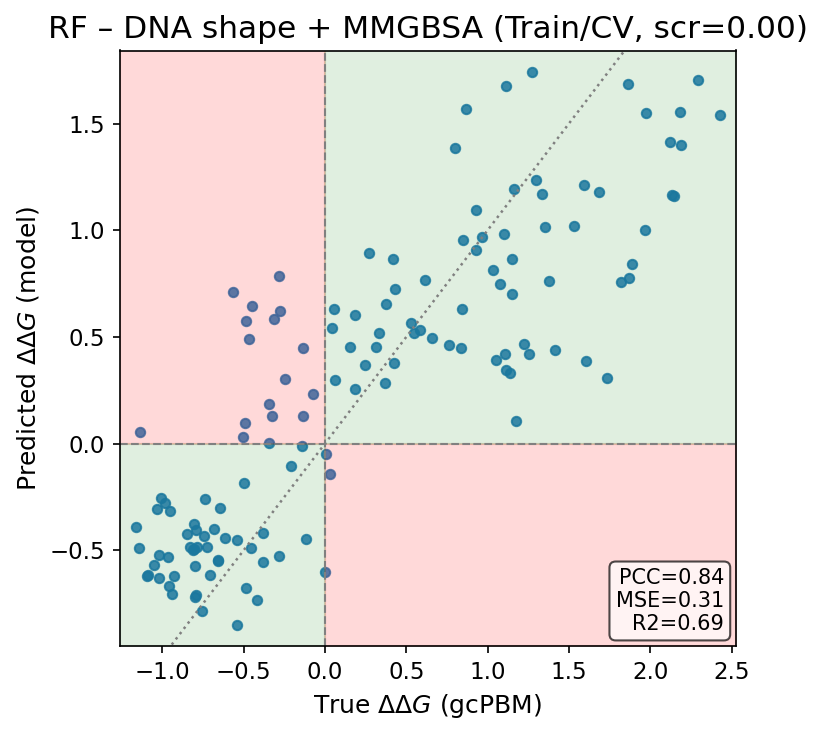

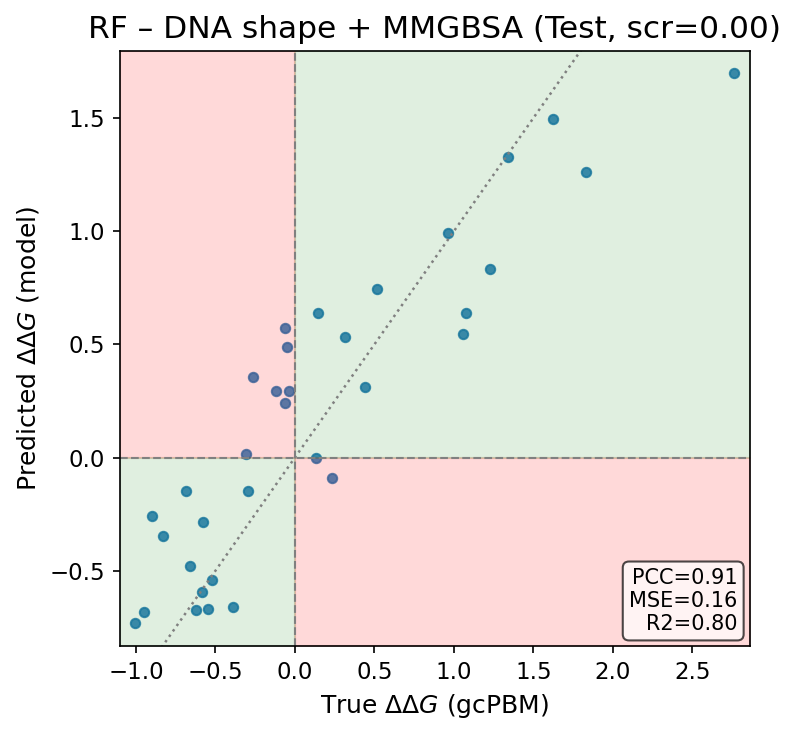

In [18]:
# ---------- filename parsing (train, test, final-avg) ----------
def parse_filename_info(file_name: str):
    """
    Train/CV:
        predictions_reg_scr0p00_rep1_fold2.csv
    Test:
        predictions_test_reg_scr0p00.csv
    Aggregated (final avg over folds):
        predictions_reg_final_avg_scr0p00.csv
    """
    m = re.match(r"^predictions_(reg)_scr([\d]+p[\d]+)_rep(\d+)_fold(\d+)\.csv$", file_name)
    if m:
        return dict(model_type="reg",
                    scr_frac=float(m.group(2).replace("p", ".")),
                    rep=int(m.group(3)), fold=int(m.group(4)),
                    is_test=False, is_final_avg=False)

    m2 = re.match(r"^predictions_test_(reg)_scr([\d]+p[\d]+)\.csv$", file_name)
    if m2:
        return dict(model_type="reg",
                    scr_frac=float(m2.group(2).replace("p", ".")),
                    rep=None, fold=None,
                    is_test=True, is_final_avg=False)

    m3 = re.match(r"^predictions_reg_final_avg_scr([\d]+p[\d]+)\.csv$", file_name)
    if m3:
        return dict(model_type="reg",
                    scr_frac=float(m3.group(1).replace("p", ".")),
                    rep=None, fold=None,
                    is_test=False, is_final_avg=True)

    return None


def load_csv_standardized(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p)
    # Normalize possible column name variants
    rename_map = {}
    if "Predicted" in df.columns:      rename_map["Predicted"] = "Predicted_reg"
    if "True" in df.columns:           rename_map["True"] = "True_reg"
    if "AvgPredicted" in df.columns:   rename_map["AvgPredicted"] = "Predicted_reg"
    if "AvgTrue" in df.columns:        rename_map["AvgTrue"] = "True_reg"
    if rename_map:
        df = df.rename(columns=rename_map)
    if not {"Predicted_reg", "True_reg"}.issubset(df.columns):
        raise ValueError(f"{p.name} is missing Predicted/True columns after renaming.")
    return df


def collect_regression_predictions(model_folder: Path) -> pd.DataFrame:
    """
    Recursively searches model_folder for predictions_*.csv and returns a unified DataFrame.
    """
    matches = list(model_folder.rglob("predictions_*.csv"))
    rows = []
    for p in matches:
        info = parse_filename_info(p.name)
        if not info:
            continue
        try:
            df = load_csv_standardized(p)
        except Exception:
            continue
        df["scr_frac"]   = info["scr_frac"]
        df["is_test"]    = info["is_test"]
        df["rep"]        = info["rep"]
        df["fold"]       = info["fold"]
        df["final_avg"]  = info["is_final_avg"]
        rows.append(df)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


# ---------- plotting ----------
def regression_scatter(true_vals, pred_vals, title, quadrant_fill=True):
    tv = np.asarray(true_vals)
    pv = np.asarray(pred_vals)

    pcc = pearsonr(tv, pv)[0] if len(tv) > 1 else np.nan
    mse = mean_squared_error(tv, pv)
    r2v = r2_score(tv, pv) if len(tv) > 1 else np.nan

    xmin, xmax = tv.min() - 0.1, tv.max() + 0.1
    ymin, ymax = pv.min() - 0.1, pv.max() + 0.1

    annotation = f"PCC={pcc:.2f}\nMSE={mse:.2f}\nR2={r2v:.2f}"

    fig, ax = plt.subplots(figsize=(5.2, 5), dpi=150)
    ax.scatter(tv, pv, s=20, alpha=0.85, color="tab:blue")

    ax.plot([xmin, xmax], [xmin, xmax], linestyle=":", color="grey", lw=1.2)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(r"True $\Delta\Delta G$ (gcPBM)", fontsize=12)
    ax.set_ylabel(r"Predicted $\Delta\Delta G$ (model)", fontsize=12)
    ax.tick_params(labelsize=11)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    if quadrant_fill:
        ax.axhline(0, color="grey", linestyle="--", lw=1)
        ax.axvline(0, color="grey", linestyle="--", lw=1)
        ax.fill_between([xmin, 0], 0,   ymax, color="red",   alpha=0.15)
        ax.fill_between([0,   xmax], ymin, 0, color="red",   alpha=0.15)
        ax.fill_between([0,   xmax], 0,   ymax, color="green", alpha=0.12)
        ax.fill_between([xmin, 0],   ymin, 0, color="green", alpha=0.12)

    ax.text(0.98, 0.02, annotation, transform=ax.transAxes,
            ha="right", va="bottom", fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    plt.tight_layout()
    plt.show()


def plot_from_df(df_reg: pd.DataFrame, model_label: str, scr_filter: float = 0.0):
    if df_reg.empty:
        print(f"[{model_label}] No regression prediction files found.")
        return

    # keep selected scramble fraction
    if "scr_frac" in df_reg.columns:
        df_reg = df_reg[np.isclose(df_reg["scr_frac"], scr_filter)]

    # helper: use per-sequence means if Label exists
    def seq_means(df):
        if "Label" in df.columns:
            g = df.groupby("Label", as_index=False)[["True_reg", "Predicted_reg"]].mean()
            return g["True_reg"].values, g["Predicted_reg"].values
        else:
            return df["True_reg"].values, df["Predicted_reg"].values

    # TRAIN (includes CV folds and final-avg files, both marked is_test=False)
    dtr = df_reg[df_reg.get("is_test", False) == False]
    if not dtr.empty:
        tv, pv = seq_means(dtr)
        regression_scatter(tv, pv, title=f"{model_label} (Train/CV, scr={scr_filter:.2f})")

    # TEST
    dte = df_reg[df_reg.get("is_test", False) == True]
    if not dte.empty:
        tv, pv = seq_means(dte)
        regression_scatter(tv, pv, title=f"{model_label} (Test, scr={scr_filter:.2f})")


MODEL_CONFIGS = {
    "RF – DNA shape + MMGBSA":   "../ML_RF_scramble_ROHS_MMGBSA",
}


for name, folder in MODEL_CONFIGS.items():
    folder = Path(folder)
    print(f"\nProcessing: {name}  ({folder})")
    df_reg = collect_regression_predictions(folder) 
    plot_from_df(df_reg, model_label=name, scr_filter=0.00)
